Используя шаблон ноутбука, напишите загрузку данных и прогнозирование акций Лукойла на 1 шаг с помощью Dense и Conv1D сетей (две отдельные сети).

Можно подсматривать в исходный ноутбук с занятия, но желательно писать код своими руками.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical 
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D, MaxPooling1D, RepeatVector #Стандартные слои
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
base_data16 = pd.read_csv('/content/drive/MyDrive/Lessons/Lesson7/16_17.csv', sep=';')
base_data18 = pd.read_csv('/content/drive/MyDrive/Lessons/Lesson7/18_19.csv', sep=';')
data16_17 = base_data16.iloc[:,2:]
data18_19 = base_data18.iloc[:,2:]

In [ ]:
data16_17.shape[0]

263925

In [ ]:
d = data18_19
print(len(d))
print(len(d.iloc[0]))
print(d.iloc[0])

217947
5
OPEN      3341.0
MAX       3356.0
MIN       3340.0
CLOSE     3355.0
VOLUME    6088.0
Name: 0, dtype: float64


In [ ]:
data = data16_17.copy()
data = pd.concat([data16_17,data18_19])
data = np.array(data)

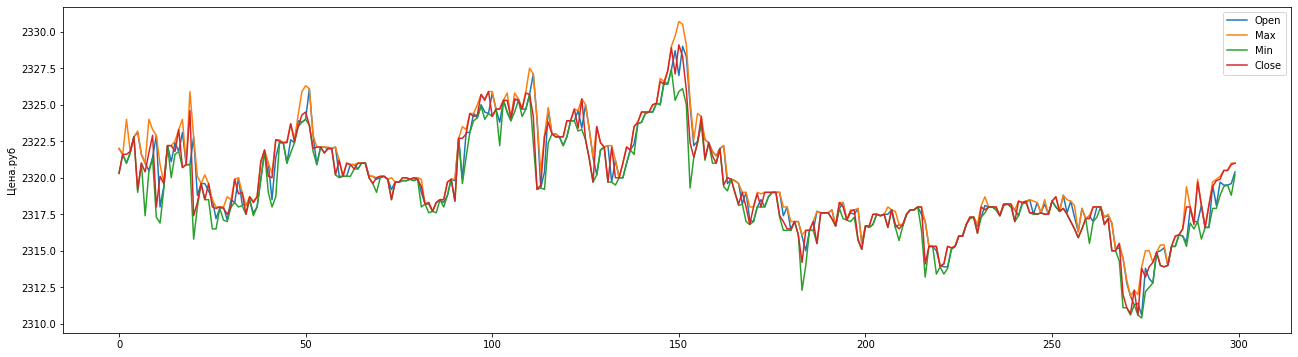

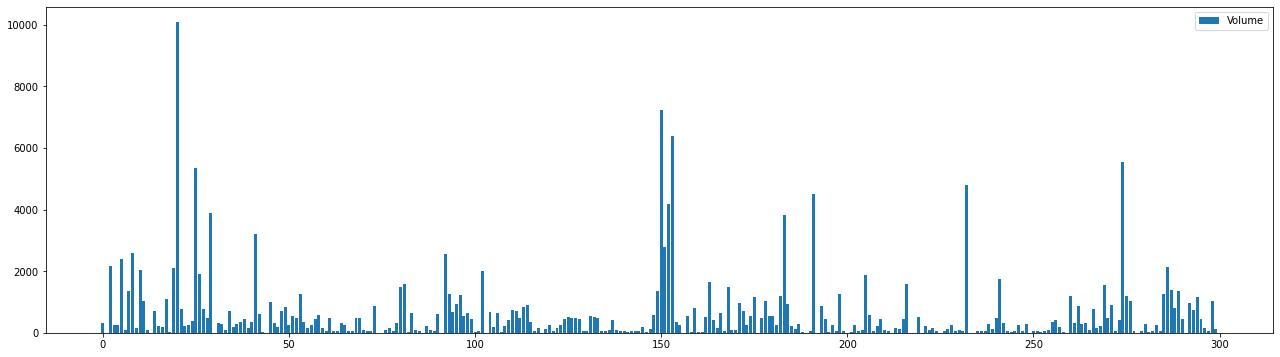

In [ ]:
start = 100
length = 300

chanelNames = ['Open', 'Max', 'Min', 'Close', 'Volume']

plt.figure(figsize=(22,6))
for i in range(4):
  plt.plot(data[start:start+length,i], 
          label=chanelNames[i])
plt.ylabel('Цена.руб')
plt.legend()
plt.show()

plt.figure(figsize=(22,6))
plt.bar(x=np.arange(length), height=data[start:start+length,4], label="Volume")
plt.legend()
plt.show()

In [ ]:
test_array = np.arange(50)
print(test_array)
x_train = test_array
y_train = test_array

gen = TimeseriesGenerator(
    x_train,
    y_train,
    length= 10,
    sampling_rate=1,
    stride=1,
    batch_size=5
    )

for i, g in enumerate(gen):
  print('Батч №', i)
  print('x_train:', g[0])
  print('y_train:', g[1])
  print()

x_train = test_array[:-1]
y_train = test_array[1:]

gen = TimeseriesGenerator(
    x_train,
    y_train,
    length= 10,
    sampling_rate=1,
    stride=1,
    batch_size=1
    )

for i, g in enumerate(gen):
  print('Батч №', i)
  print('x_train:', g[0])
  print('y_train:', g[1])
  print()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
Батч № 0
x_train: [[ 0  1  2  3  4  5  6  7  8  9]
 [ 1  2  3  4  5  6  7  8  9 10]
 [ 2  3  4  5  6  7  8  9 10 11]
 [ 3  4  5  6  7  8  9 10 11 12]
 [ 4  5  6  7  8  9 10 11 12 13]]
y_train: [10 11 12 13 14]

Батч № 1
x_train: [[ 5  6  7  8  9 10 11 12 13 14]
 [ 6  7  8  9 10 11 12 13 14 15]
 [ 7  8  9 10 11 12 13 14 15 16]
 [ 8  9 10 11 12 13 14 15 16 17]
 [ 9 10 11 12 13 14 15 16 17 18]]
y_train: [15 16 17 18 19]

Батч № 2
x_train: [[10 11 12 13 14 15 16 17 18 19]
 [11 12 13 14 15 16 17 18 19 20]
 [12 13 14 15 16 17 18 19 20 21]
 [13 14 15 16 17 18 19 20 21 22]
 [14 15 16 17 18 19 20 21 22 23]]
y_train: [20 21 22 23 24]

Батч № 3
x_train: [[15 16 17 18 19 20 21 22 23 24]
 [16 17 18 19 20 21 22 23 24 25]
 [17 18 19 20 21 22 23 24 25 26]
 [18 19 20 21 22 23 24 25 26 27]
 [19 20 21 22 23 24 25 26 27 28]]
y_train: [25 26 27 28 29]

Ба

In [ ]:
xLen = 300                     
valLen = 30000        

trainLen = data.shape[0]-valLen

xTrain, xTest = data[:trainLen], data[trainLen+xLen+2:]

xScaler = MinMaxScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

yTrain, yTest = np.reshape(data[:trainLen,3],(-1,1)), np.reshape(data[trainLen+xLen+2:,3],(-1,1)) 
yScaler = MinMaxScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)

trainDataGen = TimeseriesGenerator(xTrain, yTrain, 
                               length=xLen, stride=1, sampling_rate=1,
                               batch_size=20)


testDataGen = TimeseriesGenerator(xTest, yTest,
                               length=xLen, stride=1,
                               batch_size=20)

In [ ]:
print(trainDataGen[0][0].shape,
      trainDataGen[0][1].shape)

(20, 300, 5) (20, 1)


In [ ]:
def getPred(currModel, xVal, yVal, yScaler):

  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)
  
  return (predVal, yValUnscaled)


def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.figure(figsize=(22,6))
  plt.plot(predVal[start:start+step, 0],
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], 
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()
  

def correlate(a, b):

  ma = a.mean()
  mb = b.mean()
  mab = (a*b).mean()
  sa = a.std()
  sb = b.std()
  
  val = 1
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val


def showCorr(channels, corrSteps, predVal, yValUnscaled):

  for ch in channels:
    corr = []
    yLen = yValUnscaled.shape[0]

    for i in range(corrSteps):

      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, 0]))

    own_corr = []

     
    for i in range(corrSteps):
      own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))

    plt.figure(figsize=(14,7))
    plt.plot(corr, label='Предсказание на ' + str(ch+1) + ' шаг')
    plt.plot(own_corr, label='Эталон')

  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.show()

In [ ]:
DataGen = TimeseriesGenerator(xTest, yTest,
                               length=300, sampling_rate=1,
                               batch_size=len(xTest))
xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

In [ ]:
modelD = Sequential()
modelD.add(Dense(150,input_shape = (xLen,5), activation="relu" ))
modelD.add(Flatten())
modelD.add(Dense(1, activation="linear"))

modelD.compile(loss="mse", optimizer=Adam(lr=1e-4))

modelD.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300, 150)          900       
_________________________________________________________________
flatten (Flatten)            (None, 45000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 45001     
Total params: 45,901
Trainable params: 45,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
epochs = 25

In [ ]:
history = modelD.fit(
                    trainDataGen, 
                    epochs=epochs, 
                    verbose=1, 
                    validation_data = testDataGen 
                    )

Epoch 1/25
22579/22579 [==============================] - 134s 6ms/step - loss: 8.3402e-04 - val_loss: 5.1077e-05
Epoch 2/25
22579/22579 [==============================] - 133s 6ms/step - loss: 6.6941e-05 - val_loss: 2.8430e-04
Epoch 3/25
22579/22579 [==============================] - 133s 6ms/step - loss: 3.5182e-05 - val_loss: 3.1724e-05
Epoch 4/25
22579/22579 [==============================] - 134s 6ms/step - loss: 2.5172e-05 - val_loss: 1.1410e-04
Epoch 5/25
22579/22579 [==============================] - 131s 6ms/step - loss: 2.1009e-05 - val_loss: 1.5931e-05
Epoch 6/25
22579/22579 [==============================] - 131s 6ms/step - loss: 1.8198e-05 - val_loss: 1.5576e-05
Epoch 7/25
22579/22579 [==============================] - 131s 6ms/step - loss: 1.6093e-05 - val_loss: 1.8264e-05
Epoch 8/25
22579/22579 [==============================] - 130s 6ms/step - loss: 1.5308e-05 - val_loss: 1.2381e-05
Epoch 9/25
22579/22579 [==============================] - 131s 6ms/step - loss: 1.3582e-

In [ ]:
modelD.compile(loss="mse", optimizer=Adam(lr=1e-5))

history = modelD.fit(
                    trainDataGen, 
                    epochs=epochs, 
                    verbose=1, 
                    validation_data = testDataGen 
                    )

Epoch 1/25
22579/22579 [==============================] - 136s 6ms/step - loss: 3.4705e-06 - val_loss: 5.5437e-06
Epoch 2/25
22579/22579 [==============================] - 134s 6ms/step - loss: 3.4519e-06 - val_loss: 5.0161e-06
Epoch 3/25
22579/22579 [==============================] - 133s 6ms/step - loss: 3.4253e-06 - val_loss: 6.0744e-06
Epoch 4/25
22579/22579 [==============================] - 133s 6ms/step - loss: 3.3971e-06 - val_loss: 4.8670e-06
Epoch 5/25
22579/22579 [==============================] - 133s 6ms/step - loss: 3.3666e-06 - val_loss: 5.1622e-06
Epoch 6/25
22579/22579 [==============================] - 133s 6ms/step - loss: 3.3694e-06 - val_loss: 4.7582e-06
Epoch 7/25
22579/22579 [==============================] - 133s 6ms/step - loss: 3.3343e-06 - val_loss: 4.8579e-06
Epoch 8/25
22579/22579 [==============================] - 134s 6ms/step - loss: 3.3329e-06 - val_loss: 6.8749e-06
Epoch 9/25
22579/22579 [==============================] - 134s 6ms/step - loss: 3.3032e-

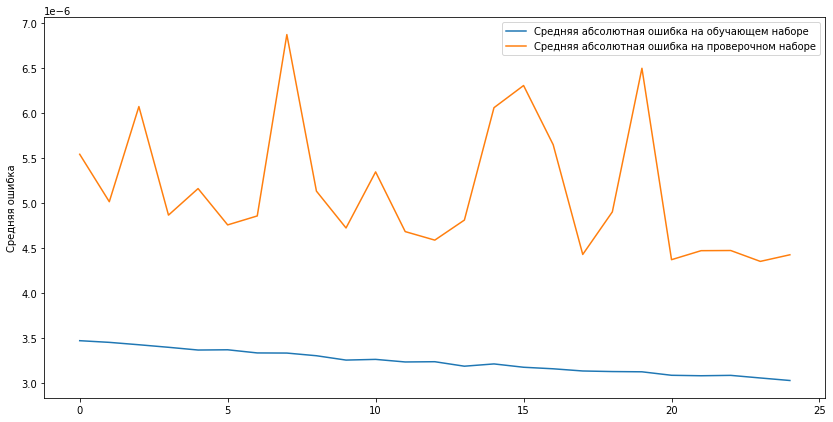

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
modelD.compile(loss="mse", optimizer=Adam(lr=1e-6))

history = modelD.fit(
                    trainDataGen, 
                    epochs=epochs, 
                    verbose=1, 
                    validation_data = testDataGen 
                    )

Epoch 1/25
22579/22579 [==============================] - 136s 6ms/step - loss: 2.7310e-06 - val_loss: 4.3409e-06
Epoch 2/25
22579/22579 [==============================] - 136s 6ms/step - loss: 2.7275e-06 - val_loss: 4.4974e-06
Epoch 3/25
22579/22579 [==============================] - 136s 6ms/step - loss: 2.7254e-06 - val_loss: 4.2519e-06
Epoch 4/25
22579/22579 [==============================] - 135s 6ms/step - loss: 2.7234e-06 - val_loss: 4.2423e-06
Epoch 5/25
22579/22579 [==============================] - 136s 6ms/step - loss: 2.7225e-06 - val_loss: 4.2332e-06
Epoch 6/25
22579/22579 [==============================] - 137s 6ms/step - loss: 2.7207e-06 - val_loss: 4.3507e-06
Epoch 7/25
22579/22579 [==============================] - 136s 6ms/step - loss: 2.7204e-06 - val_loss: 4.2290e-06
Epoch 8/25
22579/22579 [==============================] - 136s 6ms/step - loss: 2.7163e-06 - val_loss: 4.4774e-06
Epoch 9/25
22579/22579 [==============================] - 136s 6ms/step - loss: 2.7180e-

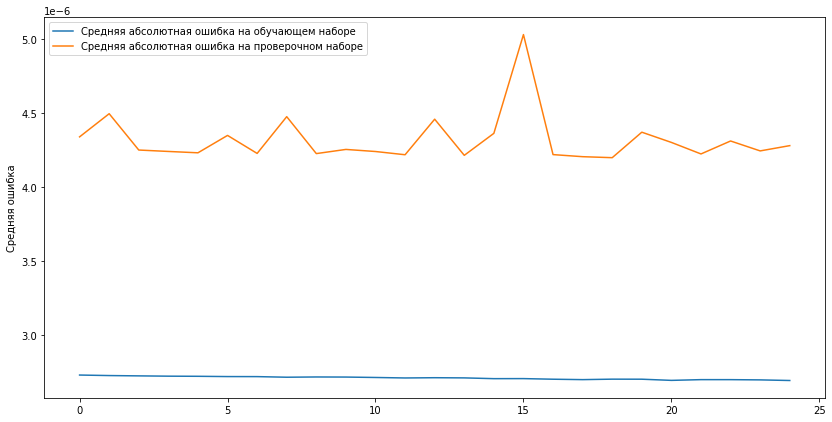

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

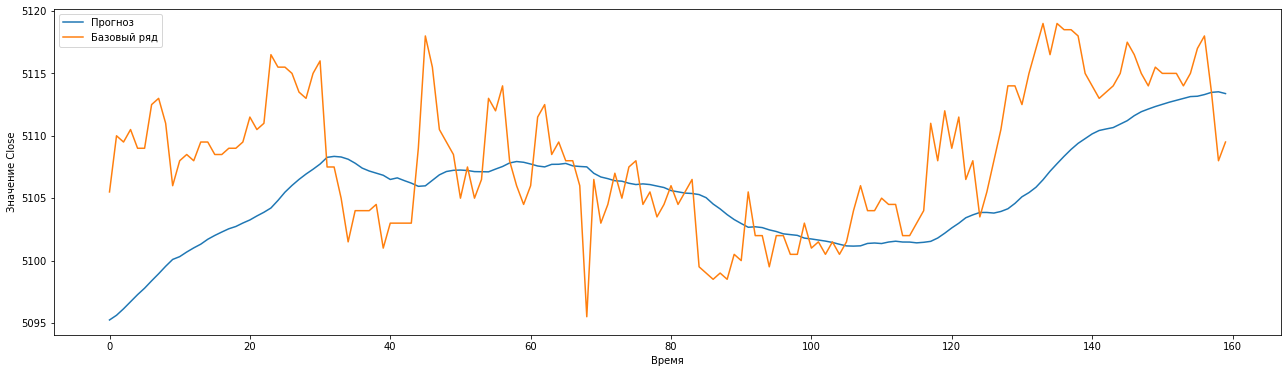

In [ ]:
currModel = modelD
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler)

showPredict(0, 160, 0, predVal, yValUnscaled)

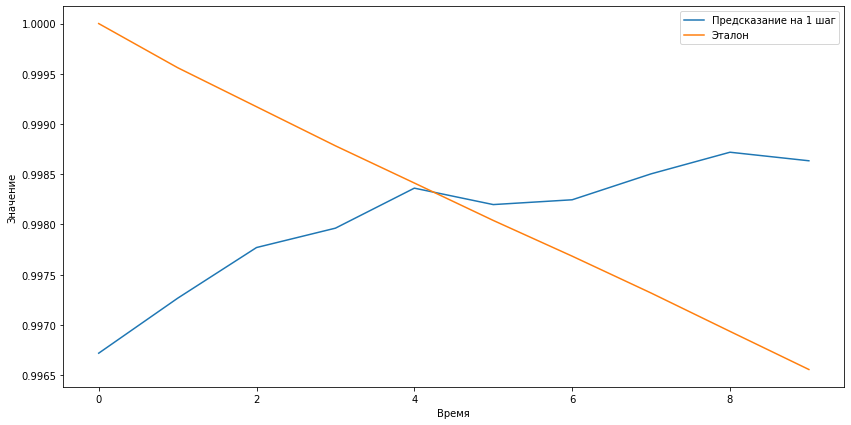

In [ ]:
showCorr([0], 10, predVal, yValUnscaled)

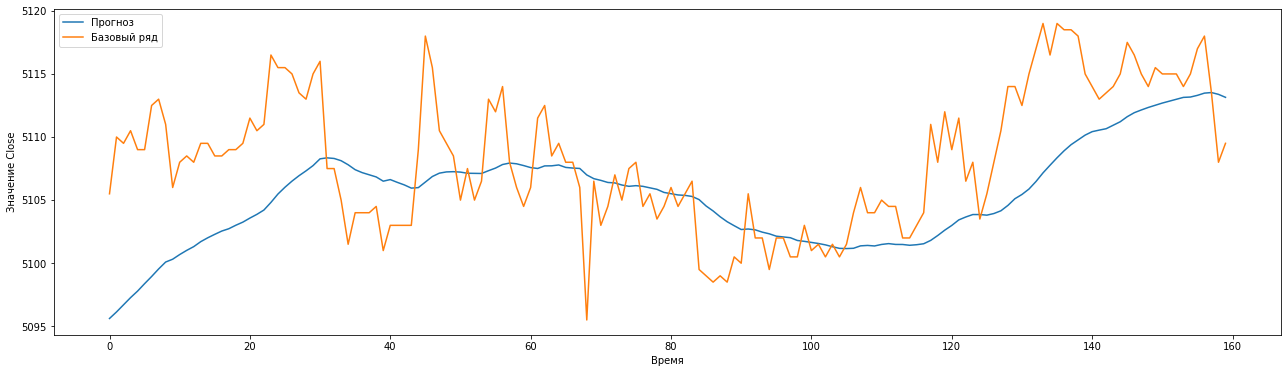

In [ ]:

currModel = modelD
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler)

showPredict(0, 160, 0, predVal[1:], yValUnscaled[:-1])


In [ ]:
del modelD

# Теперь сделаем модель, применив слой Conv1D

In [ ]:
model = Sequential()
model.add(Conv1D(16, 3, input_shape=(xLen, 5), activation="relu"))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(100, activation="relu"))
model.add(Dense(1, activation="linear"))

model.compile(loss="mse", optimizer=Adam(lr=1e-4))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 298, 16)           256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 149, 16)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2384)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               238500    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 238,857
Trainable params: 238,857
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(trainDataGen,
                    epochs=epochs, 
                    verbose=1,
                    validation_data=testDataGen)

Epoch 1/25
22579/22579 [==============================] - 128s 6ms/step - loss: 4.5483e-04 - val_loss: 1.0313e-04
Epoch 2/25
22579/22579 [==============================] - 128s 6ms/step - loss: 5.9920e-05 - val_loss: 2.2866e-05
Epoch 3/25
22579/22579 [==============================] - 128s 6ms/step - loss: 4.0009e-05 - val_loss: 2.0495e-05
Epoch 4/25
22579/22579 [==============================] - 128s 6ms/step - loss: 3.0941e-05 - val_loss: 1.4474e-05
Epoch 5/25
22579/22579 [==============================] - 128s 6ms/step - loss: 2.8942e-05 - val_loss: 8.1412e-05
Epoch 6/25
22579/22579 [==============================] - 129s 6ms/step - loss: 2.3994e-05 - val_loss: 2.1147e-04
Epoch 7/25
22579/22579 [==============================] - 128s 6ms/step - loss: 2.3814e-05 - val_loss: 2.5456e-05
Epoch 8/25
22579/22579 [==============================] - 129s 6ms/step - loss: 1.9319e-05 - val_loss: 6.0982e-05
Epoch 9/25
22579/22579 [==============================] - 128s 6ms/step - loss: 1.8843e-

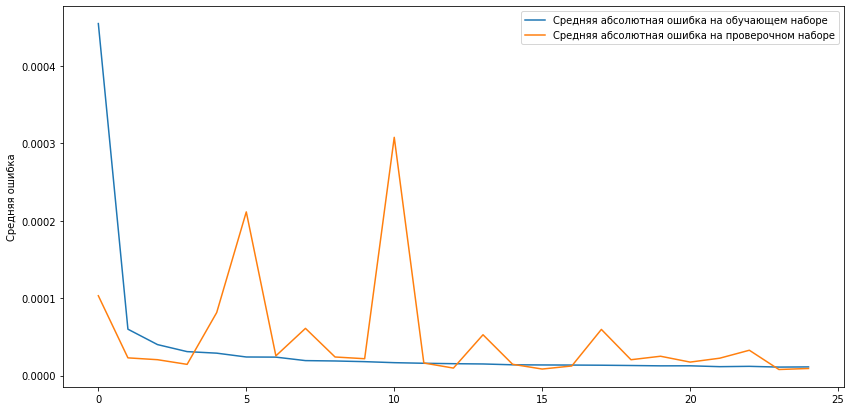

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
currModel = model
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler)

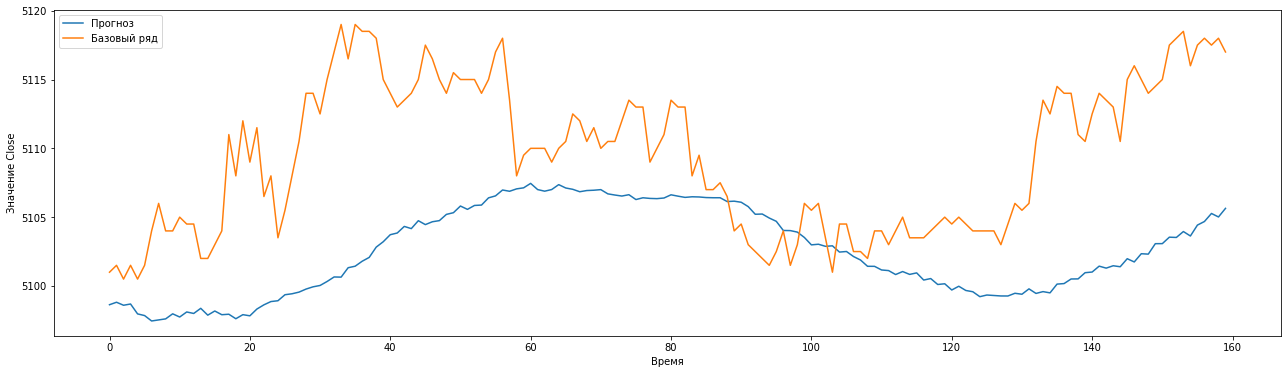

In [ ]:
showPredict(100, 160, 0, predVal, yValUnscaled)

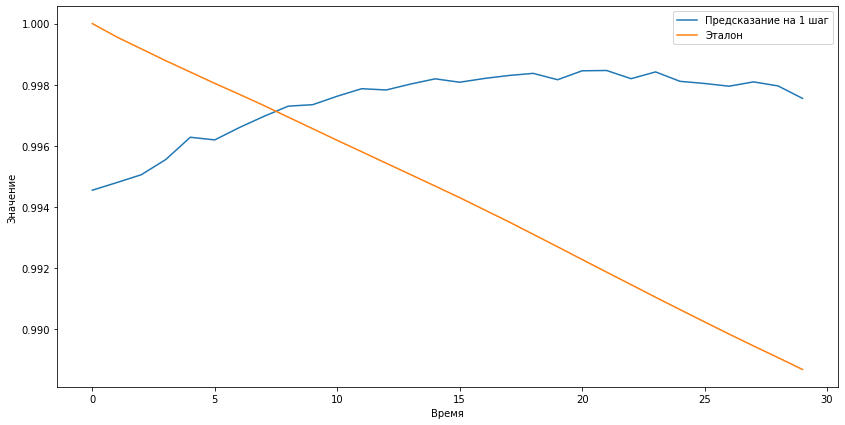

In [ ]:
showCorr([0], 30, predVal, yValUnscaled)

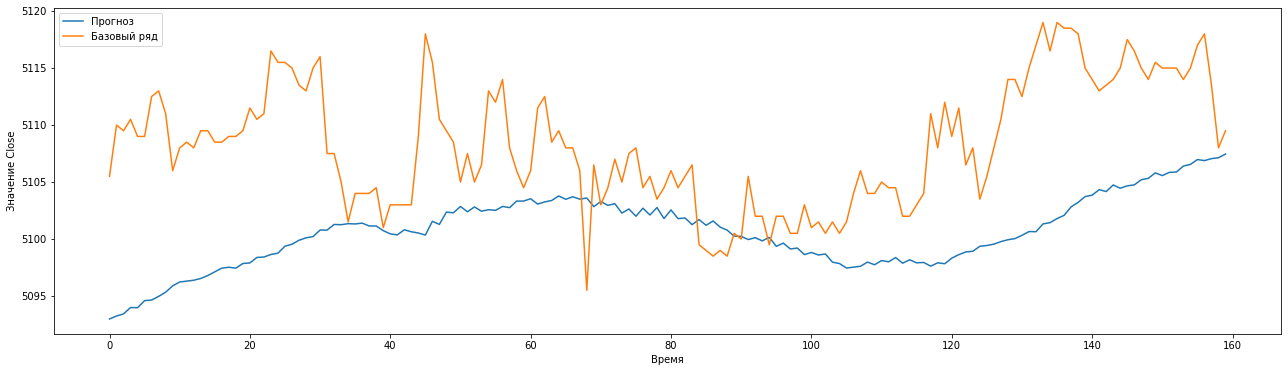

In [ ]:
currModel = model
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler)

showPredict(0, 160, 0, predVal[1:], yValUnscaled[:-1])


In [ ]:
model.compile(loss="mse", optimizer=Adam(lr=1e-5))
history = model.fit(trainDataGen,
                    epochs=epochs, 
                    verbose=1,
                    validation_data=testDataGen)

Epoch 1/25
22579/22579 [==============================] - 124s 5ms/step - loss: 4.5485e-06 - val_loss: 7.9323e-06
Epoch 2/25
22579/22579 [==============================] - 124s 5ms/step - loss: 4.4027e-06 - val_loss: 7.0016e-06
Epoch 3/25
22579/22579 [==============================] - 124s 6ms/step - loss: 4.3552e-06 - val_loss: 8.8057e-06
Epoch 4/25
22579/22579 [==============================] - 125s 6ms/step - loss: 4.3446e-06 - val_loss: 6.9626e-06
Epoch 5/25
22579/22579 [==============================] - 127s 6ms/step - loss: 4.2825e-06 - val_loss: 8.0515e-06
Epoch 6/25
22579/22579 [==============================] - 125s 6ms/step - loss: 4.2460e-06 - val_loss: 7.2059e-06
Epoch 7/25
22579/22579 [==============================] - 125s 6ms/step - loss: 4.2165e-06 - val_loss: 6.2168e-06
Epoch 8/25
22579/22579 [==============================] - 126s 6ms/step - loss: 4.1767e-06 - val_loss: 6.1076e-06
Epoch 9/25
22579/22579 [==============================] - 125s 6ms/step - loss: 4.1732e-

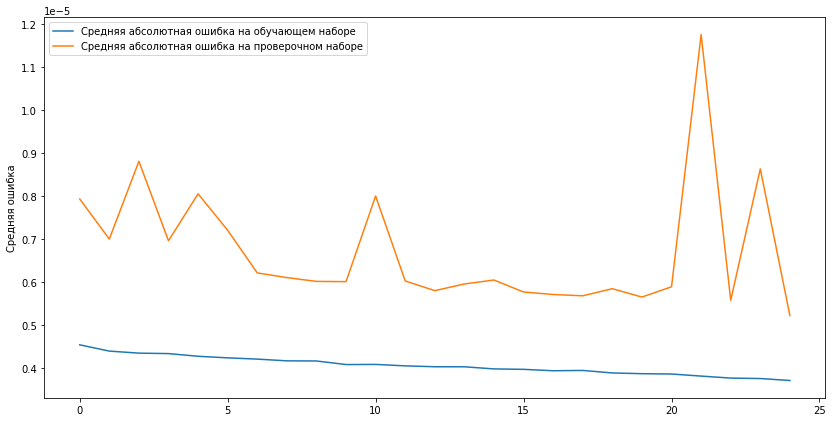

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

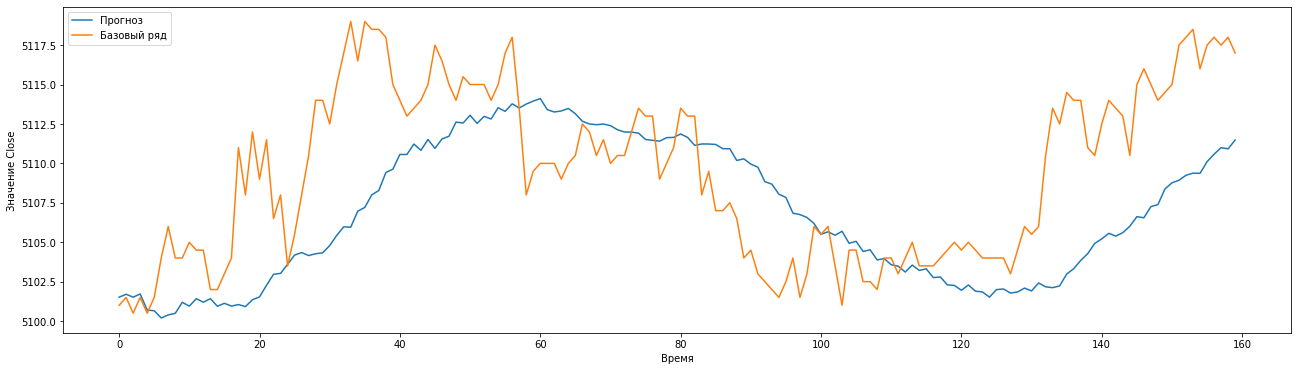

In [ ]:
currModel = model
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler)

showPredict(100, 160, 0, predVal, yValUnscaled)

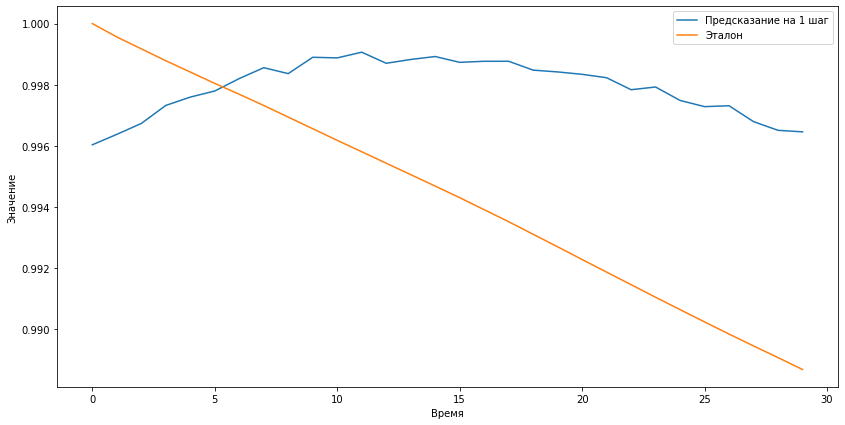

In [ ]:
showCorr([0], 30, predVal, yValUnscaled)

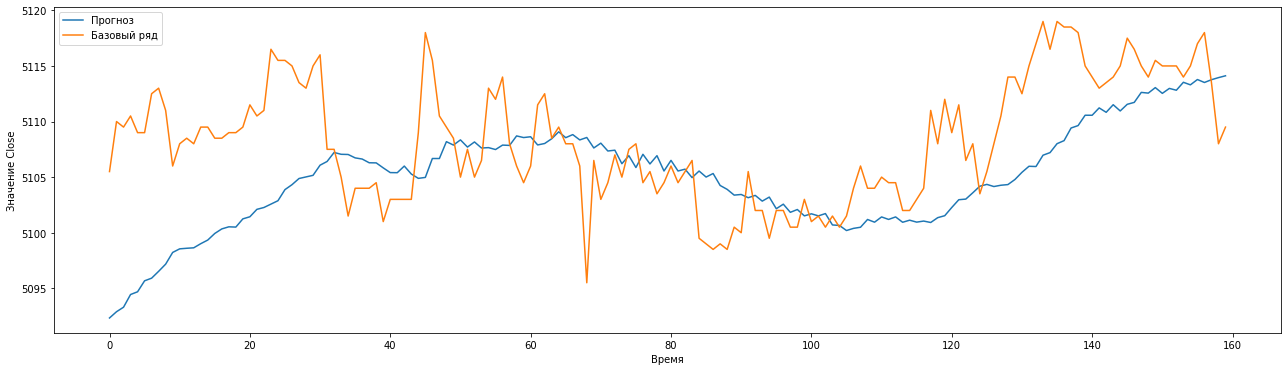

In [ ]:

currModel = model
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler)


showPredict(0, 160, 0, predVal[1:], yValUnscaled[:-1])
